In [7]:
import os
import gzip
import pickle
import numpy as np
import torch
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from tqdm import tqdm
from model import Network
import networkx as nx
from external_world import ExternalWorld, MNISTExternalWorld

def hopfield(layers, weights, biases):
    """Compute the energy function E for the current layers."""
    # squared_norm: for each layer, sum of squares of each row, then sum over layers.
    squared_norm = sum([(layer * layer).sum(dim=1) for layer in layers]) / 2.0
    # linear_terms: for each layer, compute dot(layer, bias).
    linear_terms = -sum([torch.matmul(layer, b) for layer, b in zip(layers, biases)])
    # quadratic_terms: for each adjacent pair of layers.
    quadratic_terms = -sum([
        ((torch.matmul(pre, W)) * post).sum(dim=1)
        for pre, W, post in zip(layers[:-1], weights, layers[1:])
    ])
    return squared_norm + linear_terms + quadratic_terms

def jaynes():
    #TODO
    pass

def plot_network_structure(net: Network):
    G = nx.DiGraph()
    layer_labels = ['Input'] + [f'Hidden {i+1}' for i in range(len(net.hyperparameters["hidden_sizes"]))] + ['Output']

    # Add nodes explicitly with subset attribute
    for layer_idx, layer_label in enumerate(layer_labels):
        layer_size = net.weights[0].shape[0] if layer_idx == 0 else net.weights[layer_idx - 1].shape[1]
        for neuron_idx in range(layer_size):
            G.add_node((layer_label, neuron_idx), subset=layer_idx)

    # Add edges
    for idx, W in enumerate(net.weights):
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                G.add_edge((layer_labels[idx], i), (layer_labels[idx + 1], j))

    pos = nx.multipartite_layout(G)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=False, node_size=50, arrowsize=5)
    plt.title("Network Structure")
    plt.show()

def plot_network_weights(net: Network, epoch):
    G = nx.DiGraph()
    layer_labels = ['Input'] + [f'Hidden {i+1}' for i in range(len(net.hyperparameters["hidden_sizes"]))] + ['Output']

    for i, layer_size in enumerate([net.weights[0].shape[0]] + [w.shape[1] for w in net.weights]):
        for n in range(layer_size):
            G.add_node((layer_labels[i], n), subset=i)

    for idx, W in enumerate(net.weights):
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                weight = W[i, j].item()
                G.add_edge((layer_labels[idx], i), (layer_labels[idx+1], j), weight=weight)

    pos = nx.multipartite_layout(G, subset_key='subset')
    edge_weights = np.array([G[u][v]['weight'] for u, v in G.edges()])

    plt.figure(figsize=(5, 2))
    
    # Normalize edge colors and explicitly create a ScalarMappable
    norm = plt.Normalize(vmin=-np.max(np.abs(edge_weights)), vmax=np.max(np.abs(edge_weights)))
    cmap = plt.cm.RdYlGn

    edges = nx.draw_networkx_edges(G, pos, edge_color=edge_weights, edge_cmap=cmap, edge_vmin=norm.vmin, edge_vmax=norm.vmax, arrowsize=10)
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='gray')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(edge_weights)
    plt.colorbar(sm, label='Weight magnitude', ax = plt.gca())

    plt.title(f"Network Structure at Epoch {epoch}")
    plt.axis('off')
    plt.show()


def train_net(net: Network, plot_graph = False):
    history = {"Energy": [], "Cost": [], "Error": []}
    epochs, batch_size = net.hyperparameters["n_epochs"], net.hyperparameters["batch_size"]
    n_batches = net.dataset_size // batch_size
    n_it_neg, n_it_pos, alphas = net.hyperparameters["n_it_neg"], net.hyperparameters["n_it_pos"], net.hyperparameters["alphas"]


    snapshot_epochs = np.linspace(0, epochs - 1, 5, dtype=int)
    with tqdm(total=epochs, desc="Training Progress", unit="epoch") as epoch_bar:
        for epoch in range(epochs):
            for i in range(n_batches):
                net.update_mini_batch_index(i)
                net.negative_phase(n_it_neg)
                net.positive_phase(n_it_pos, *alphas)

            # Measure and log
            E, C, error = net.measure()
            history["Energy"].append(E)
            history["Cost"].append(C)
            history["Error"].append(error * 100)

            # Update progress bar description instead of using set_postfix()
            epoch_bar.set_description(f"Epoch {epoch+1}/{epochs} | E={E:.2f} C={C:.5f} Error={error*100:.2f}%")
            epoch_bar.update(1)
            if(plot_graph):
                if epoch in snapshot_epochs:
                    plot_network_weights(net, epoch)

    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    for ax, (key, color) in zip(axes, [("Energy", "blue"), ("Cost", "orange"), ("Error", "red")]):
        ax.plot(history[key], label=key, color=color)
        ax.set_title(f"{key} over Epochs")
    plt.tight_layout()
    plt.show()



In [8]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import pickle
from util.activation import *
from util.energy import *

class Network:
    def __init__(self, name, external_world, hyperparameters={}):
        self.path = name + ".save"
        self.external_world = external_world
        self.hyperparameters = hyperparameters

        input_size = external_world.x.shape[1]
        output_size = hyperparameters.get("output_size", len(torch.unique(external_world.y)))
        layer_sizes = [input_size] + hyperparameters["hidden_sizes"] + [output_size]

        self.biases, self.weights, self.training_curves = self._initialize_params(layer_sizes)
        self.batch_size = hyperparameters["batch_size"]
        self.dataset_size = external_world.size_dataset
        self.persistent_particles = [torch.zeros((self.dataset_size, size)) for size in layer_sizes[1:]]
        self.index = 0

    def _initialize_params(self, layer_sizes):
        biases = [torch.zeros(size) for size in layer_sizes]
        weights = [torch.tensor(np.random.uniform(-np.sqrt(6 / (n_in + n_out)), 
                        np.sqrt(6 / (n_in + n_out)), (n_in, n_out)), dtype=torch.float32)
                   for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:])]
        return biases, weights, {"training error": [], "validation error": []}

    def update_mini_batch_index(self, index):
        start, end = index * self.batch_size, (index + 1) * self.batch_size
        self.x_data, self.y_data = self.external_world.x[start:end], self.external_world.y[start:end]
        output_size = self.hyperparameters["output_size"]
        self.y_data_one_hot = F.one_hot(self.y_data, num_classes=output_size).float()
        self.layers = [self.x_data] + [p[start:end] for p in self.persistent_particles]

    def energy(self, layers):
        """Compute the energy function E for the current layers."""
        energy_fn = self.hyperparameters["energy_fn"] if "energy_fn" in self.hyperparameters else "hopfield"

        if energy_fn == 'none':
            pass
        elif energy_fn == 'hopfield':
            return hopfield(layers, self.weights, self.biases)
        else:
            raise ValueError('Unknown energy function type: {}'.format(energy_fn))

    def cost(self, layers):
        # Squared error cost between the last layer and the one-hot labels.
        return ((layers[-1] - self.y_data_one_hot) ** 2).sum(dim=1)
    
    def activation(self, neurons):
        """Compute the activation of the given neurons' values."""
        activation = self.hyperparameters["activation"] if "activation" in self.hyperparameters else "pi"
        return get_activation(activation, neurons)
    
    def measure(self):
        """Measure the average energy, cost, and error over the current mini-batch."""
        E = self.energy(self.layers).mean().item()
        C = self.cost(self.layers).mean().item()
        y_prediction = self.layers[-1].argmax(dim=1)
        error = (y_prediction != self.y_data).float().mean().item()
        return E, C, error
    
    def negative_phase(self, n_iterations):
        """Perform the negative phase relaxation (forward pass)."""
        # Copy the current mini-batch layers to iterate on.
        current_layers = [layer.clone() for layer in self.layers]
        for _ in range(n_iterations):
            new_layers = [current_layers[0]]  # input layer remains clamped.
            # For hidden layers (except the final output layer).
            for k in range(1, len(self.layers) - 1):
                hidden_input = (torch.matmul(new_layers[-1], self.weights[k - 1]) +
                                torch.matmul(current_layers[k + 1], self.weights[k].t()) +
                                self.biases[k])
                new_layers.append(self.activation(hidden_input))
            # Compute output layer.
            output_input = torch.matmul(new_layers[-1], self.weights[-1]) + self.biases[-1]
            new_layers.append(self.activation(output_input))
            current_layers = new_layers
        # Update the persistent particles for the current mini-batch.
        start = self.index * self.batch_size
        end = (self.index + 1) * self.batch_size
        for i in range(len(self.persistent_particles)):
            self.persistent_particles[i][start:end] = current_layers[i + 1].detach()
        self.layers = [self.x_data] + [p[start:end] for p in self.persistent_particles]
    
    def positive_phase(self, n_iterations, *alphas):
        """Perform the positive phase (backprop-like relaxation and parameter update)."""
        batch_size = self.x_data.shape[0]
        # Initialize the backprop scan: all layers except last remain unchanged,
        # and the final layer is replaced by the clamped one-hot label.
        initial_layers = self.layers[:-1] + [self.y_data_one_hot]
        current_layers = [layer.clone() for layer in initial_layers]
        for _ in range(n_iterations):
            new_layers = [current_layers[-1]]  # start with the top layer.
            # Backpropagate from the top hidden layer to the second layer.
            for k in range(len(self.layers) - 2, 0, -1):
                back_input = (torch.matmul(self.layers[k - 1], self.weights[k - 1]) +
                              torch.matmul(new_layers[-1], self.weights[k].t()) +
                              self.biases[k])
                new_layers.append(self.activation(back_input))
            new_layers.append(self.layers[0])
            new_layers.reverse()
            current_layers = new_layers
        # Compute the difference (Delta) between the new layers and the persistent ones (skipping the input).
        Delta_layers = [new - old for new, old in zip(current_layers[1:], self.layers[1:])]
        # Update biases for layers 1 to end.
        for i, delta in enumerate(Delta_layers, start=1):
            self.biases[i] = self.biases[i] + alphas[i - 1] * delta.mean(dim=0)
        # Update weights for each connection.
        for i, delta in enumerate(Delta_layers):
            self.weights[i] = self.weights[i] + alphas[i] * (self.layers[i].t() @ delta) / batch_size


    def save_params(self):
        biases_values = [b.detach().numpy() for b in self.biases]
        weights_values = [W.detach().numpy() for W in self.weights]
        to_dump = (biases_values, weights_values, self.hyperparameters, self.training_curves)
        with open(self.path, "wb") as f:
            pickle.dump(to_dump, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    def __load_params(self, hyperparameters):
        hyper = hyperparameters.copy()
        if os.path.isfile(self.path):
            with open(self.path, "rb") as f:
                biases_values, weights_values, saved_hyper, training_curves = pickle.load(f)
            saved_hyper.update(hyper)
            hyper = saved_hyper
        else:
            layer_sizes = [28 * 28] + hyper["hidden_sizes"] + [10]
            biases_values = [np.zeros((size,), dtype=np.float32) for size in layer_sizes]
            weights_values = []
            # Glorot/Bengio weight initialization for each layer.
            for n_in, n_out in zip(layer_sizes[:-1], layer_sizes[1:]):
                limit = np.sqrt(6.0 / (n_in + n_out))
                W = np.random.uniform(low=-limit, high=limit, size=(n_in, n_out)).astype(np.float32)
                weights_values.append(W)
            training_curves = {"training error": [], "validation error": []}
        
        # Convert loaded parameters to torch tensors.
        biases = [torch.tensor(b, dtype=torch.float32) for b in biases_values]
        weights = [torch.tensor(W, dtype=torch.float32) for W in weights_values]
        return biases, weights, hyper, training_curves
    def clamp(self, x_batch, y_batch=None):
        """Clamp x (and optionally y) and rebuild layers for a forward pass."""
        self.x_data = x_batch
        self.y_data = y_batch if y_batch is not None else torch.zeros(x_batch.size(0), dtype=torch.long)
        output_size = self.hyperparameters.get("output_size", 10)
        self.y_data_one_hot = F.one_hot(self.y_data, num_classes=output_size).float()
        
        # Create fresh internal state for evaluation (no persistent particles)
        self.layers = [self.x_data]
        for k in range(len(self.weights)):
            size = self.weights[k].shape[1]  # output size of this layer
            self.layers.append(torch.zeros((x_batch.size(0), size)))





In [9]:
def evaluate_test_batch(net, n_samples=100, n_iter=20):
    """Evaluate test performance using a forward relaxation pass."""
    x_batch = net.external_world.x_test[:n_samples]
    y_batch = net.external_world.y_test[:n_samples]

    net.x_data = x_batch
    net.y_data = y_batch

    net.clamp(x_batch, y_batch)
    net.negative_phase(n_iterations=n_iter)

    preds = net.layers[-1].argmax(dim=1)
    error = (preds != y_batch).float().mean().item()

    return error * 100  # percent


def train_net(net, plot_graph=False, test_every=1):
    history = {
        "Energy": [], "Cost": [], "Error": [],
        "TestError": []
    }

    epochs = net.hyperparameters["n_epochs"]
    batch_size = net.hyperparameters["batch_size"]
    n_batches = net.dataset_size // batch_size
    n_it_neg = net.hyperparameters["n_it_neg"]
    n_it_pos = net.hyperparameters["n_it_pos"]
    alphas = net.hyperparameters["alphas"]

    snapshot_epochs = np.linspace(0, epochs - 1, 5, dtype=int)

    with tqdm(total=epochs, desc="Training Progress", unit="epoch") as epoch_bar:
        for epoch in range(epochs):
            for i in range(n_batches):
                net.update_mini_batch_index(i)
                net.negative_phase(n_it_neg)
                net.positive_phase(n_it_pos, *alphas)

            # Train stats
            E, C, error = net.measure()
            history["Energy"].append(E)
            history["Cost"].append(C)
            history["Error"].append(error * 100)

            # Test stats
            if epoch % test_every == 0 or epoch == epochs - 1:
                error_test = evaluate_test_batch(net)
                history["TestError"].append(error_test)
            else:
                history["TestError"].append(None)

            epoch_bar.set_description(
                f"Epoch {epoch+1}/{epochs} | E={E:.2f} C={C:.5f} TrainErr={error*100:.2f}%"
                + (f" TestErr={error_test:.2f}%" if epoch % test_every == 0 else "")
            )
            epoch_bar.update(1)

            if plot_graph and epoch in snapshot_epochs:
                plot_network_weights(net, epoch)

    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].plot(history["Error"], label="Train Error", color="red", linestyle="-")
    axes[0].plot([e for e in history["TestError"] if e is not None], label="Test Error", color="red", linestyle="--")
    axes[0].set_title("Error over Epochs")
    axes[0].legend()

    axes[1].plot(history["Energy"], label="Energy", color="blue")
    axes[1].set_title("Energy over Epochs")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    return history


Epoch 10/10 | E=-77.75 C=0.13620 TrainErr=9.00% TestErr=13.00%: 100%|██████████| 10/10 [00:04<00:00,  2.36epoch/s]


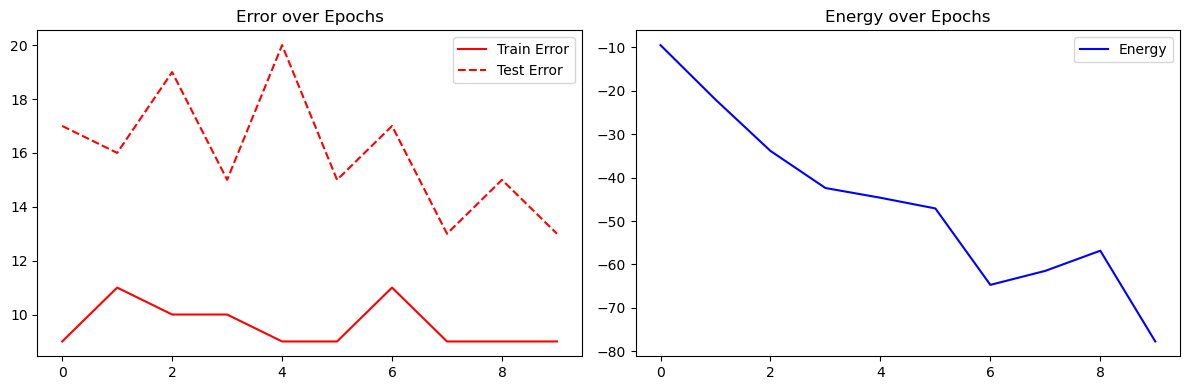

{'Energy': [-9.483263969421387,
  -22.022275924682617,
  -33.851768493652344,
  -42.4000244140625,
  -44.64228820800781,
  -47.10693359375,
  -64.71591186523438,
  -61.48662185668945,
  -56.84269714355469,
  -77.75452423095703],
 'Cost': [0.1905885487794876,
  0.18702569603919983,
  0.1826675534248352,
  0.1869710087776184,
  0.20095191895961761,
  0.18352815508842468,
  0.19861677289009094,
  0.15076155960559845,
  0.17491291463375092,
  0.13619500398635864],
 'Error': [9.000000357627869,
  10.999999940395355,
  10.000000149011612,
  10.000000149011612,
  9.000000357627869,
  9.000000357627869,
  10.999999940395355,
  9.000000357627869,
  9.000000357627869,
  9.000000357627869],
 'TestError': [17.000000178813934,
  15.999999642372131,
  18.99999976158142,
  15.000000596046448,
  20.000000298023224,
  15.000000596046448,
  17.000000178813934,
  12.999999523162842,
  15.000000596046448,
  12.999999523162842]}

In [10]:
import os
import gzip
import pickle
import numpy as np
import torch
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx


class ExternalWorld:
    def __init__(self, n_per_class=5000, n_test_per_class=200, noise_std=0.02, seed=42):
        
        path = os.path.join(os.getcwd(), "mnist.pkl.gz")
        if not os.path.isfile(path):
            urlretrieve("http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz", path)
        with gzip.open(path, "rb") as f:
            train, valid, test = pickle.load(f, encoding="latin1")

        x_all = np.vstack((train[0], valid[0], test[0]))
        y_all = np.hstack((train[1], valid[1], test[1]))

        np.random.seed(seed)

        x_train_list, y_train_list = [], []
        x_test_list, y_test_list = [], []

        for digit in range(10):
            idxs = np.where(y_all == digit)[0]
            chosen = np.random.choice(idxs, n_per_class + n_test_per_class, replace=False)
            x_train_list.append(x_all[chosen[:n_per_class]])
            y_train_list.append(np.full(n_per_class, digit))
            x_test_list.append(x_all[chosen[n_per_class:]])
            y_test_list.append(np.full(n_test_per_class, digit))

        x_train = np.vstack(x_train_list).astype(np.float32)
        y_train = np.hstack(y_train_list).astype(np.int64)
        x_test = np.vstack(x_test_list).astype(np.float32)
        y_test = np.hstack(y_test_list).astype(np.int64)

        # Shuffle training data
        train_perm = np.random.permutation(len(x_train))
        test_perm = np.random.permutation(len(x_test))

        self.x = torch.tensor(x_train[train_perm])
        self.y = torch.tensor(y_train[train_perm])
        self.x_test = torch.tensor(x_test[test_perm])
        self.y_test = torch.tensor(y_test[test_perm])
        self.size_dataset = len(self.x)








mnist_net = Network("mnist", ExternalWorld(), {
    "hidden_sizes": [500],
    "n_epochs": 10,
    "batch_size": 100,
    "n_it_neg": 1,
    "n_it_pos": 1,
    "alphas": [np.float32(0.1), np.float32(0.5), np.float32(0.4)],
    "output_size": 10,
})
# Initialize and train
train_net(mnist_net)








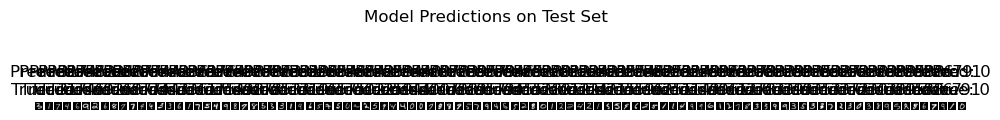

In [70]:

import matplotlib.pyplot as plt

def show_predictions(net, test_x, test_y, n_samples=100):
    """Use the trained model to predict digits and display them."""
    # Take a batch from the test set
    x_batch = test_x[:n_samples]
    y_batch = test_y[:n_samples]

    # Inject into network
    net.x_data = x_batch
    net.y_data = y_batch

    # Run a short forward relaxation to settle the network
    net.clamp(x_batch, y_batch)
    net.negative_phase(n_iterations=20)

    # Get predictions from the output layer
    preds = net.layers[-1].argmax(dim=1).cpu().numpy()
    # print(net.layers[-1])
    images = x_batch.view(-1, 28, 28).cpu().numpy()
    true_labels = y_batch.cpu().numpy()

    # Plot a few predictions
    plt.figure(figsize=(12, 2))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.title(f"Pred: {preds[i]}\nTrue: {true_labels[i]}")
        plt.axis("off")
    plt.suptitle("Model Predictions on Test Set")
    plt.show()


show_predictions(mnist_net, mnist_net.external_world.x_test, mnist_net.external_world.y_test)


[0.         0.21973696 0.0324537  0.         0.21378192 0.01535566
 0.19780733 0.01457553 0.16195866 0.18769568]
0
[0.23422877 0.         0.1667697  0.20382583 0.         0.17984314
 0.00399393 0.19450913 0.0408605  0.01364269]
0
[0.         0.21973696 0.0324537  0.         0.21378192 0.01535566
 0.19780733 0.01457553 0.16195866 0.18769568]
0
[0.23422877 0.         0.1667697  0.20382583 0.         0.17984314
 0.00399393 0.19450913 0.0408605  0.01364269]
0
[0.23422877 0.         0.1667697  0.20382583 0.         0.17984314
 0.00399393 0.19450913 0.0408605  0.01364269]
0
[0.         0.21973696 0.0324537  0.         0.21378192 0.01535566
 0.19780733 0.01457553 0.16195866 0.18769568]
0
[0.         0.21973696 0.0324537  0.         0.21378192 0.01535566
 0.19780733 0.01457553 0.16195866 0.18769568]
0
[0.12575582 0.         0.1382728  0.15035324 0.         0.14494498
 0.04511397 0.15633386 0.06655305 0.0505703 ]
0


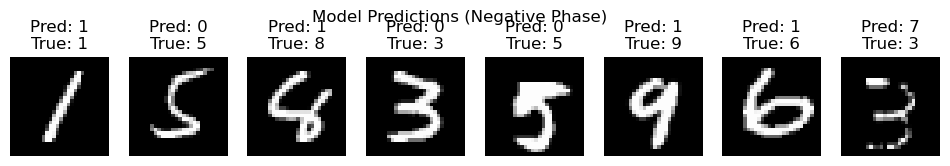

In [14]:
import matplotlib.pyplot as plt

def show_predictions(net, n_samples=8):
    """Use the trained model to predict digits and display them."""
    # Pick the first mini-batch
    net.update_mini_batch_index(0)

    # Run a short forward relaxation to settle the network
    net.negative_phase(n_iterations=20)

    # Get predictions from the output layer
    
    preds = net.layers[-1].argmax(dim=1).cpu().numpy()
    
    true_labels = net.y_data.cpu().numpy()
    images = net.x_data.view(-1, 28, 28).cpu().numpy()

    # Plot a few predictions
    plt.figure(figsize=(12, 2))
    for i in range(n_samples):
        print(net.layers[-1].cpu().numpy()[i])
        print(0)
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.title(f"Pred: {preds[i]}\nTrue: {true_labels[i]}")
        plt.axis("off")
    plt.suptitle("Model Predictions (Negative Phase)")
    plt.show()

show_predictions(mnist_net)

In [32]:
def mcmc_trajectory(net, x, n_steps=200, layer_noise_std=0.02):
    """
    Clamp input x, run MCMC on hidden/output layers, and record energy over time.
    
    Args:
        net: trained Network
        x: input image, shape [1, input_dim]
        n_steps: number of MCMC steps
        layer_noise_std: proposal noise std for hidden/output layers

    Returns:
        energies: list of scalar energies
        states: list of full layer states (e.g. for PCA)
        preds: list of predicted class at each step
    """
    with torch.no_grad():
        x = x.view(1, -1)
        weights = [W.clone() for W in net.weights]
        biases = [b.clone() for b in net.biases]

        # Initialize layers (x is clamped)
        layers = [x] + [
            torch.randn(1, b.shape[0]) * 0.01 for b in biases[1:]
        ]
        energies = []
        preds = []
        states = []

        for step in range(n_steps):
            proposal = [x]
            for l in layers[1:]:
                proposal.append(l + torch.randn_like(l) * layer_noise_std)
            
            E_current = hopfield(layers, weights, biases)
            E_proposal = hopfield(proposal, weights, biases)

            # Accept/reject
            accept_prob = torch.exp(E_current - E_proposal)
            if torch.rand(1) < accept_prob:
                layers = proposal

            # Log
            energies.append(hopfield(layers, weights, biases).item())
            preds.append(layers[-1].argmax(dim=1).item())
            states.append(torch.cat(layers[1:], dim=1).squeeze().cpu().numpy())

        return energies, preds, states


In [33]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_mcmc_energy_and_class(energies, preds):
    plt.figure(figsize=(12, 4))

    # Energy
    plt.subplot(1, 2, 1)
    plt.plot(energies, label='Energy')
    plt.xlabel("Step")
    plt.ylabel("Energy")
    plt.title("Energy over MCMC Steps")
    plt.grid(True)
    
    # Class
    plt.subplot(1, 2, 2)
    plt.plot(preds, label='Predicted Class', color='purple')
    plt.xlabel("Step")
    plt.ylabel("Class")
    plt.title("Predicted Class over MCMC Steps")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def plot_mcmc_pca(states, preds=None, color_by='time'):
    """
    Visualize MCMC trajectory in 2D using PCA.
    color_by: 'time' or 'class'
    """
    states_np = np.array(states)
    pca = PCA(n_components=2)
    projected = pca.fit_transform(states_np)

    plt.figure(figsize=(6, 6))
    if color_by == 'time':
        plt.scatter(projected[:, 0], projected[:, 1], c=np.arange(len(states)), cmap='viridis', s=10)
        plt.colorbar(label='MCMC Step')
        plt.title("MCMC Trajectory (PCA, colored by time)")
    elif color_by == 'class' and preds is not None:
        plt.scatter(projected[:, 0], projected[:, 1], c=preds, cmap='tab20', s=10)
        plt.colorbar(label='Predicted Class')
        plt.title("MCMC Trajectory (PCA, colored by class)")

    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.show()


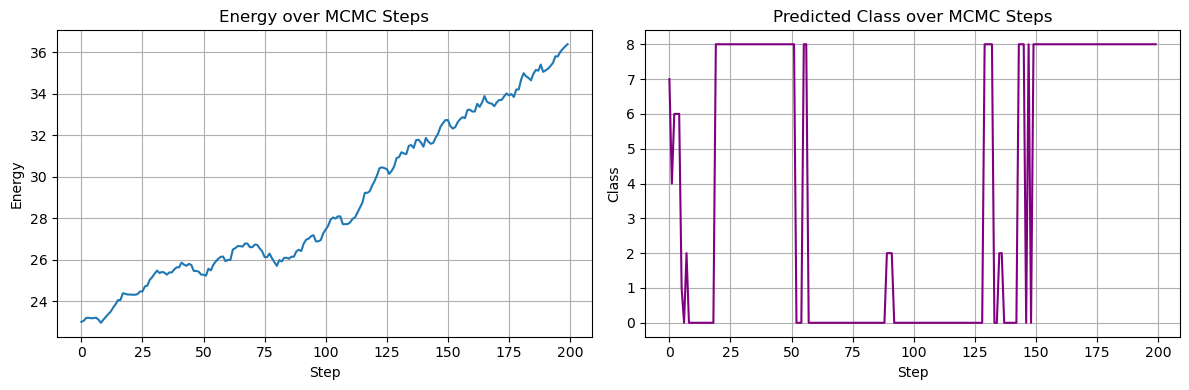

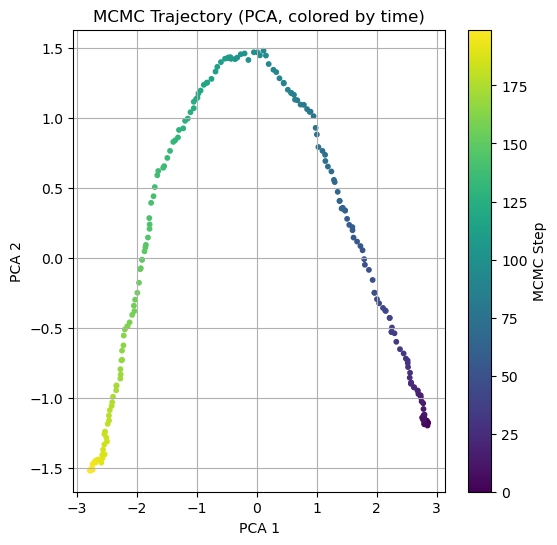

In [34]:
x_sample = mnist_net.external_world.x[0].unsqueeze(0)  # one real digit
energies, preds, states = mcmc_trajectory(mnist_net, x_sample, n_steps=200)

plot_mcmc_energy_and_class(energies, preds)
plot_mcmc_pca(states, preds, color_by='time')   # Or 'class'


In [35]:
from collections import defaultdict

def collect_mcmc_trajectories(net, samples_per_class=5, n_steps=200):
    xs = net.external_world.x
    ys = net.external_world.y
    all_states = []
    all_labels = []
    all_preds = []

    class_counts = defaultdict(int)
    max_per_class = samples_per_class

    for i in range(len(xs)):
        label = ys[i].item()
        if class_counts[label] >= max_per_class:
            continue

        x_sample = xs[i].unsqueeze(0)
        energies, preds, states = mcmc_trajectory(net, x_sample, n_steps=n_steps)
        
        all_states.extend(states)
        all_labels.extend([label] * len(states))
        all_preds.extend(preds)
        class_counts[label] += 1

        if sum(class_counts.values()) >= samples_per_class * 22:
            break

    return np.array(all_states), np.array(all_labels), np.array(all_preds)


In [37]:
from sklearn.manifold import TSNE

def plot_tsne(states, labels, title="MCMC t-SNE"):
    tsne = TSNE(n_components=2, perplexity=30, init='random', random_state=42)
    reduced = tsne.fit_transform(states)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab20', s=5, alpha=0.8)
    plt.colorbar(scatter, label="Original Class")
    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.grid(True)
    plt.show()


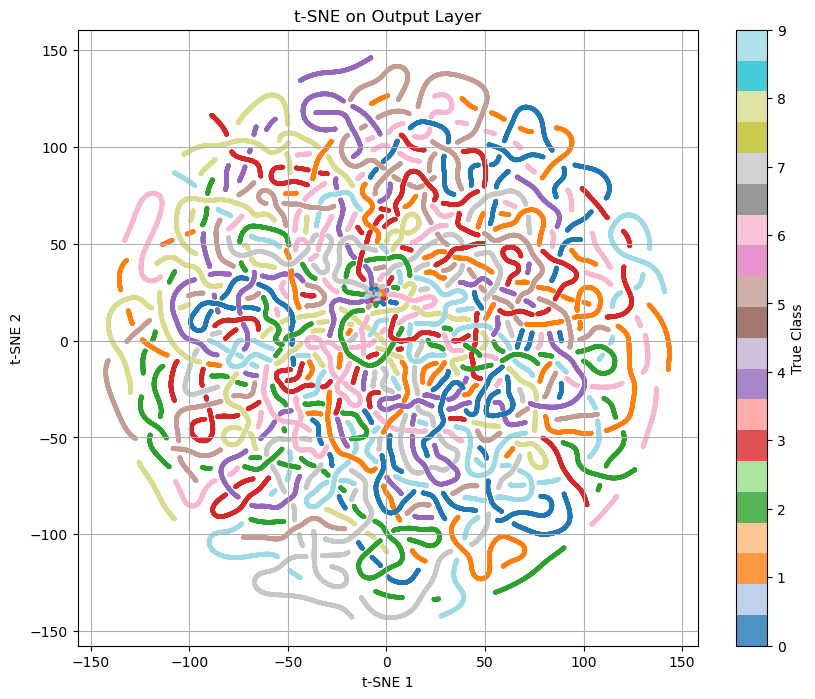

In [50]:
states, labels, preds = collect_mcmc_trajectories(mnist_net, samples_per_class=5, n_steps=2000)
plot_tsne(states, labels)


In [39]:
def combine_state(hidden, output, output_weight=5.0):
    return torch.cat([hidden, output * output_weight], dim=1)


def collect_mcmc_trajectories_weighted(net, samples_per_class=5, n_steps=200, output_weight=5.0):
    xs = net.external_world.x
    ys = net.external_world.y
    all_states = []
    all_labels = []
    all_preds = []

    class_counts = defaultdict(int)
    for i in range(len(xs)):
        label = ys[i].item()
        if class_counts[label] >= samples_per_class:
            continue

        x_sample = xs[i].unsqueeze(0)
        energies, preds, states = mcmc_trajectory(net, x_sample, n_steps=n_steps)

        for s in states:
            hidden = s[:net.weights[0].shape[1]]     # hidden size
            output = s[net.weights[0].shape[1]:]      # output size
            full_state = np.concatenate([hidden, output * output_weight])
            all_states.append(full_state)

        all_labels.extend([label] * len(states))
        all_preds.extend(preds)
        class_counts[label] += 1

        if sum(class_counts.values()) >= samples_per_class * 22:
            break

    return np.array(all_states), np.array(all_labels), np.array(all_preds)


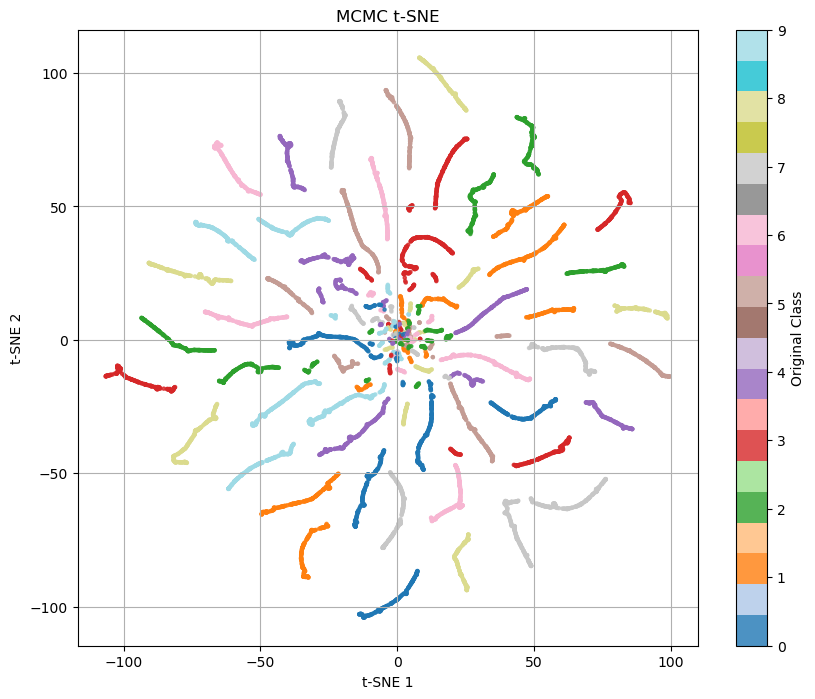

In [41]:
states, labels, preds = collect_mcmc_trajectories_weighted(mnist_net, output_weight=50.0)
plot_tsne(states, labels)


In [46]:
def mcmc_trajectory_output_only(net, x, n_steps=200, layer_noise_std=0.02):
    """
    Run MCMC and record only the output layer (for class-focused t-SNE).
    """
    with torch.no_grad():
        x = x.view(1, -1)
        weights = [W.clone() for W in net.weights]
        biases = [b.clone() for b in net.biases]

        # Initialize hidden/output layers
        layers = [x] + [torch.randn(1, b.shape[0]) * 0.01 for b in biases[1:]]
        output_trajectory = []
        preds = []

        for step in range(n_steps):
            # Propose new hidden/output
            proposal = [x] + [l + torch.randn_like(l) * layer_noise_std for l in layers[1:]]
            E_current = hopfield(layers, weights, biases)
            E_proposal = hopfield(proposal, weights, biases)

            accept_prob = torch.exp(E_current - E_proposal)
            if torch.rand(1) < accept_prob:
                layers = proposal

            output_layer = layers[-1].squeeze().cpu().numpy()
            output_trajectory.append(output_layer)
            preds.append(layers[-1].argmax(dim=1).item())

        return output_trajectory, preds


In [47]:
from collections import defaultdict

def collect_output_only_trajectories(net, samples_per_class=5, n_steps=200):
    xs, ys = net.external_world.x, net.external_world.y
    all_outputs, all_labels, all_preds = [], [], []
    class_counts = defaultdict(int)

    for i in range(len(xs)):
        label = ys[i].item()
        if class_counts[label] >= samples_per_class:
            continue

        x_sample = xs[i].unsqueeze(0)
        outputs, preds = mcmc_trajectory_output_only(net, x_sample, n_steps=n_steps)

        all_outputs.extend(outputs)
        all_labels.extend([label] * len(outputs))
        all_preds.extend(preds)
        class_counts[label] += 1

        if sum(class_counts.values()) >= samples_per_class * 22:
            break

    return np.array(all_outputs), np.array(all_labels), np.array(all_preds)


In [48]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(states, labels, title="t-SNE on Output Layer"):
    tsne = TSNE(n_components=2, perplexity=30, init='random', random_state=42)
    reduced = tsne.fit_transform(states)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab20', s=5, alpha=0.8)
    plt.colorbar(scatter, label="True Class")
    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.grid(True)
    plt.show()


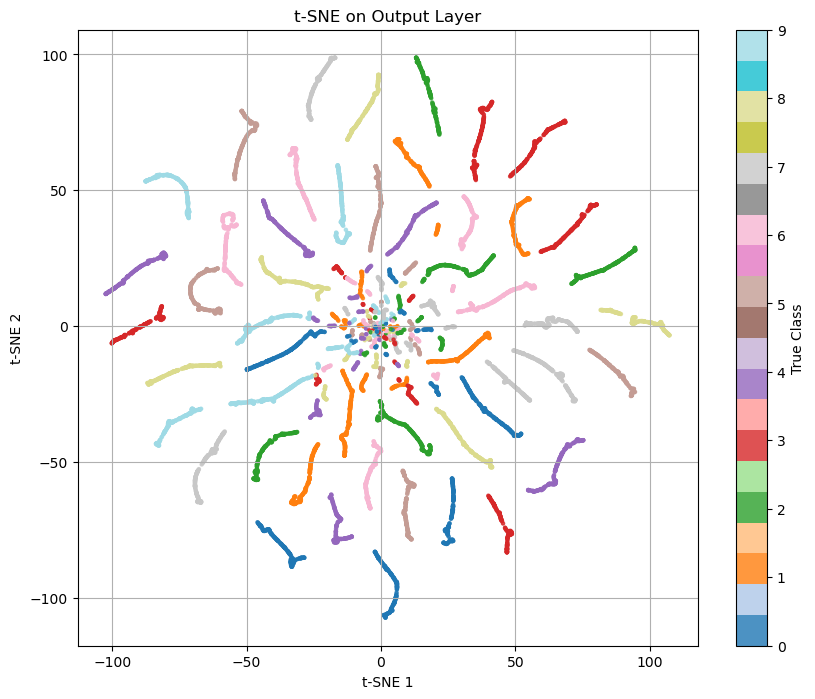

In [49]:
# Run everything
states, labels, preds = collect_output_only_trajectories(mnist_net, samples_per_class=5, n_steps=200)
plot_tsne(states, labels)


In [21]:
def sample_inputs_via_langevin(model, y_target, n_steps=50, step_size=0.1, noise_scale=0.01):
    input_dim = model.weights[0].shape[0]         # Now correctly 784
    batch_size = y_target.shape[0]

    x = torch.randn(batch_size, input_dim, requires_grad=True)

    samples = []
    for t in range(n_steps):
        layers = [x]
        for i in range(len(model.weights)):
            z = torch.matmul(layers[-1], model.weights[i]) + model.biases[i]
            layers.append(model.activation(z))

        layers[-1] = y_target  # clamp output

        energy = model.energy(layers).sum()
        energy.backward()

        with torch.no_grad():
            x -= 0.5 * step_size * x.grad
            x += noise_scale * torch.randn_like(x)
            x.grad.zero_()
            samples.append(x.clone())

    return samples


In [23]:
digit = 3
y = F.one_hot(torch.tensor([digit]), num_classes=22).float().unsqueeze(0) * 10

samples = sample_inputs_via_langevin(mnist_net, y, n_steps=100)

plt.imshow(samples[-1].detach().cpu().view(28, 28), cmap='gray')
plt.title("Langevin sample for class 3")
plt.axis("off")
plt.show()


RuntimeError: The size of tensor a (500) must match the size of tensor b (784) at non-singleton dimension 1

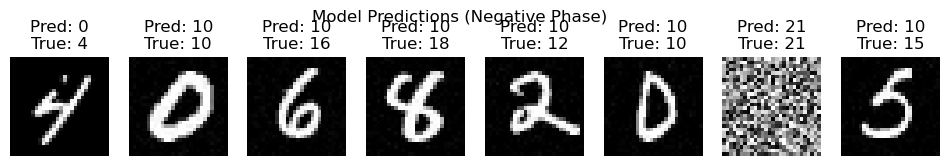

In [4]:
import matplotlib.pyplot as plt

def show_predictions(net, n_samples=8):
    """Use the trained model to predict digits and display them."""
    # Pick the first mini-batch
    net.update_mini_batch_index(0)

    # Run a short forward relaxation to settle the network
    net.negative_phase(n_iterations=20)

    # Get predictions from the output layer
    preds = net.layers[-1].argmax(dim=1).cpu().numpy()
    true_labels = net.y_data.cpu().numpy()
    images = net.x_data.view(-1, 28, 28).cpu().numpy()

    # Plot a few predictions
    plt.figure(figsize=(12, 2))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.title(f"Pred: {preds[i]}\nTrue: {true_labels[i]}")
        plt.axis("off")
    plt.suptitle("Model Predictions (Negative Phase)")
    plt.show()

show_predictions(mnist_net)

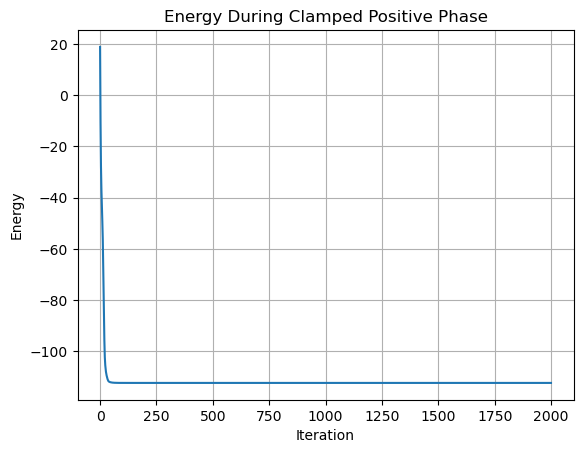

tensor([[10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


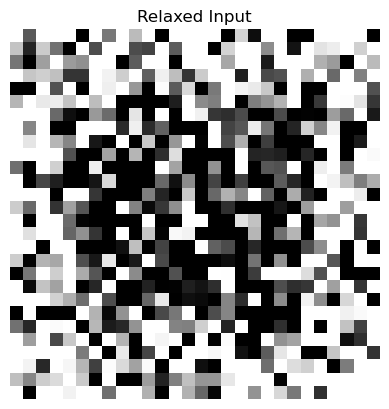

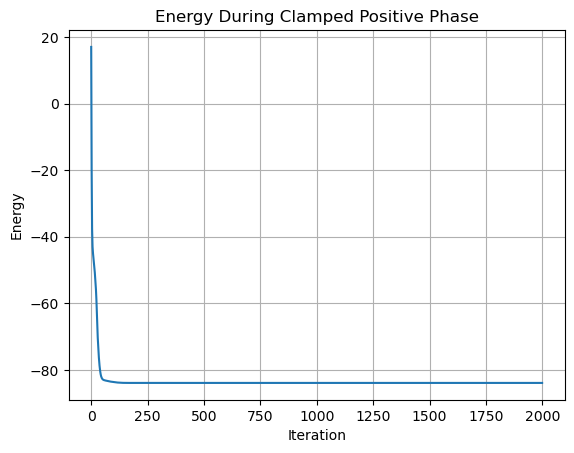

tensor([[ 0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


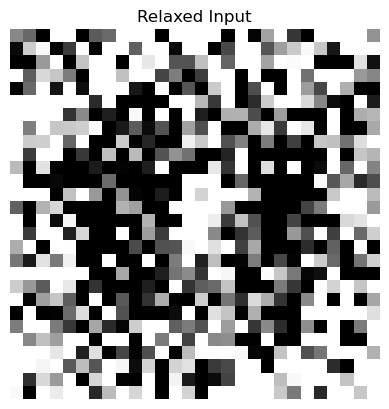

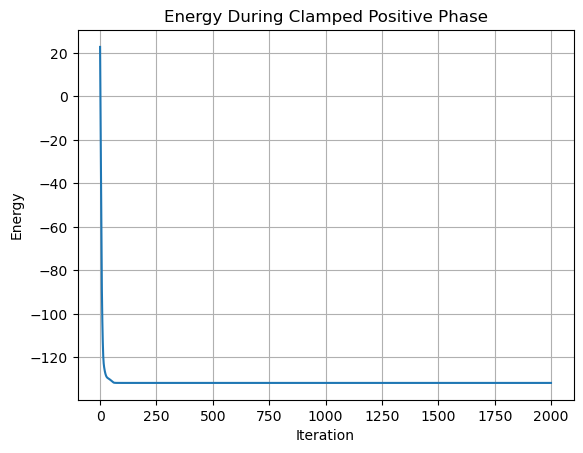

tensor([[ 0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


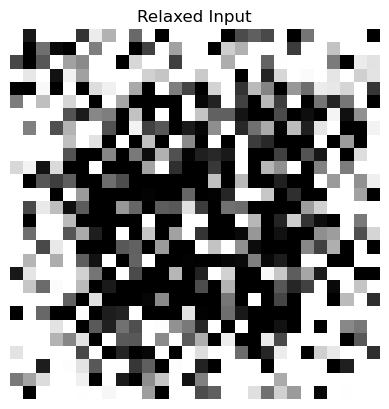

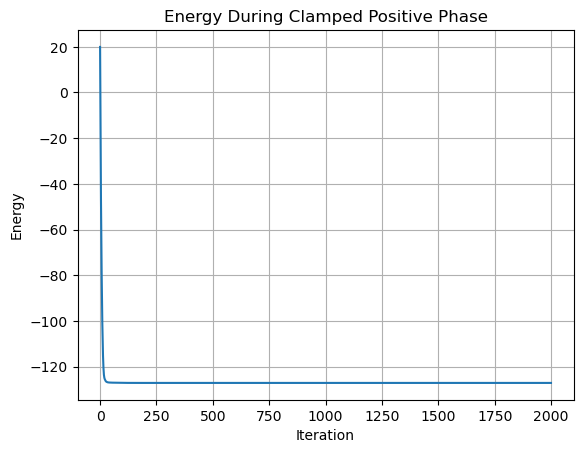

tensor([[ 0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


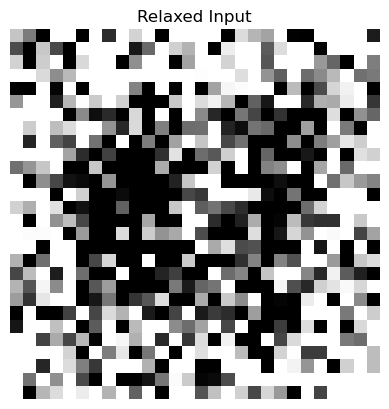

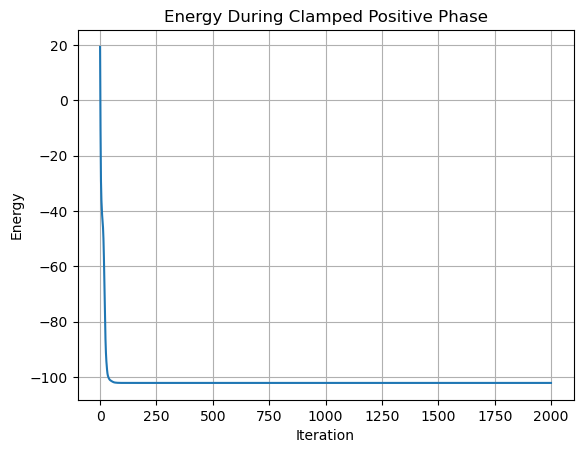

tensor([[ 0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


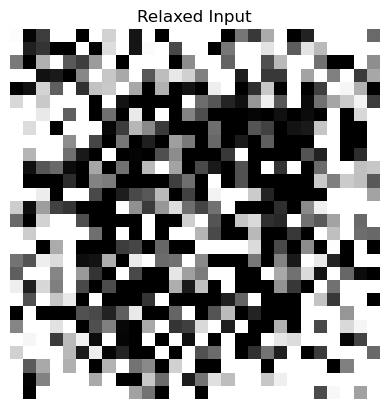

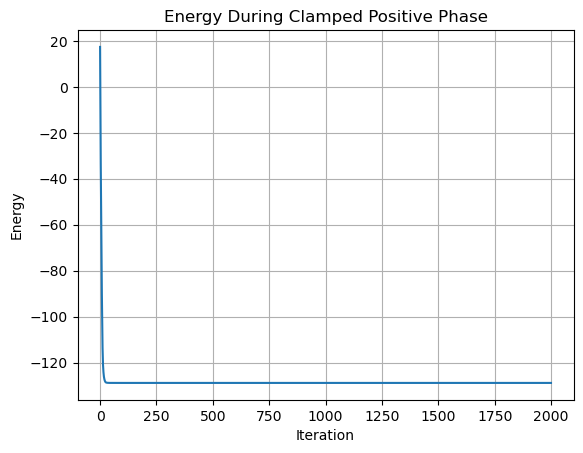

tensor([[ 0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


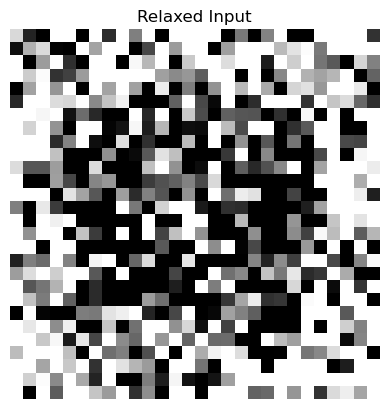

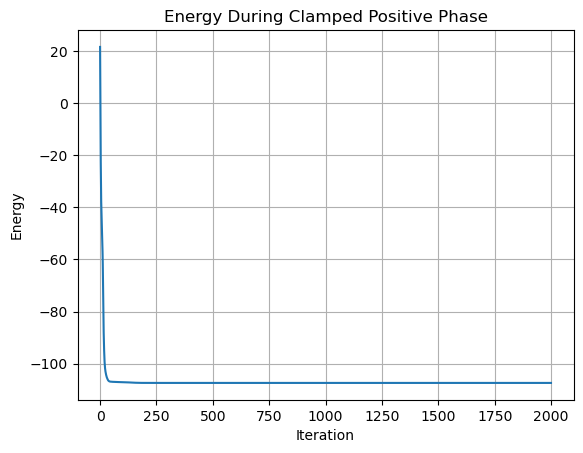

tensor([[ 0.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


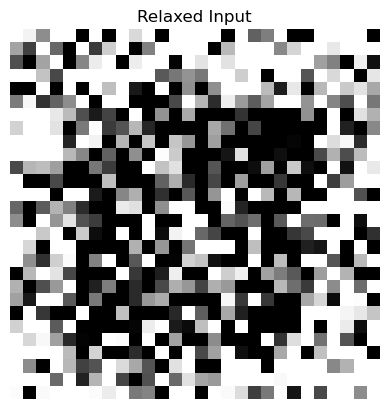

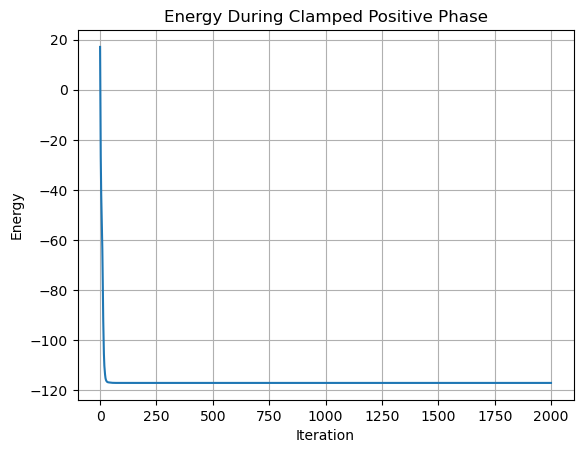

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


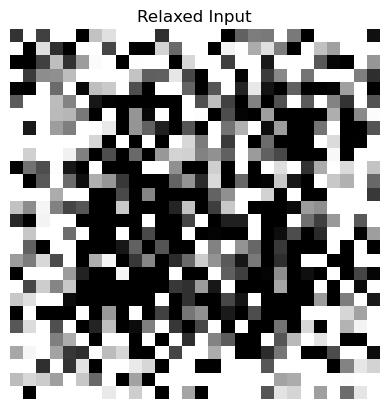

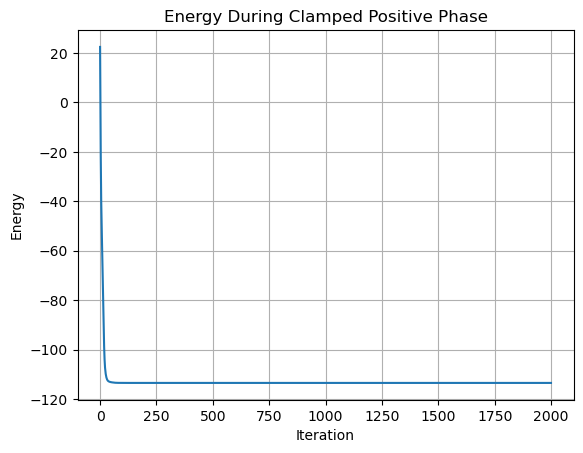

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


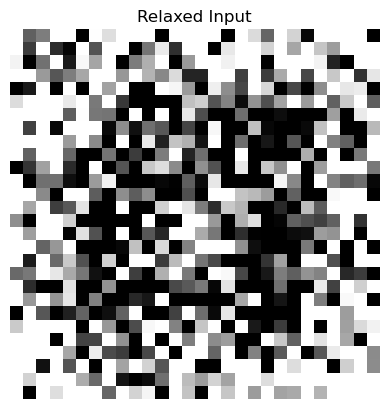

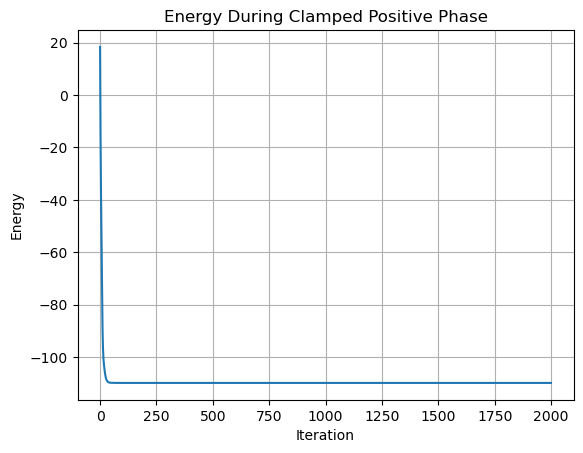

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


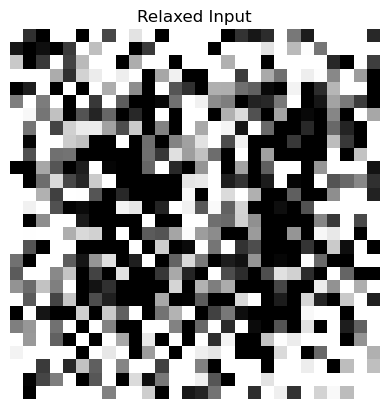

In [12]:
class ClampingNetwork(Network):

    # --- Initialization ---
    def initialize_layers(self, clamp_dict, num_layers, batch_size):
        return [self._init_layer(i, clamp_dict, num_layers, batch_size) for i in range(num_layers)]

    def _init_layer(self, i, clamp_dict, num_layers, batch_size):
        if i in clamp_dict:
            return clamp_dict[i].clone()
        elif i == 0:
            return torch.randn(batch_size, self.weights[0].shape[0]) * 0.1
        else:
            return torch.zeros(batch_size, self.weights[i - 1].shape[1])

    # --- Relaxation ---
    def relax_layers(self, current, clamp_dict):
        num_layers = len(current)
        new = [None] * num_layers

        for i in reversed(range(num_layers)):
            new[i] = self._relax_layer(i, current, new, clamp_dict)

            # new[i] = self._relax_layer(i, current, new, clamp_dict)

        return new

    def _relax_layer(self, i, current, new, clamp_dict):
        if i in clamp_dict:
            # print(f"Layer {i} is clamped")
            return clamp_dict[i].clone()

        if i == 0:
            # print(f"Updating layer {i} using: L1")
            return self._update_input_layer(current)

        if i == len(current) - 1:
            # print(f"Updating layer {i} using: L{len(current)-2}")
            return self._update_output_layer(current)

        # print(f"Updating layer {i} using: L{i-1}, L{i+1}")
        return self._update_hidden_layer(i, current, new)




    def _update_input_layer(self, current):
        return self.activation(torch.matmul(current[1], self.weights[0].t()) + self.biases[0])

    def _update_hidden_layer(self, i, current, new):
        return self.activation(
            torch.matmul(current[i - 1], self.weights[i - 1]) +
            torch.matmul(current[i + 1], self.weights[i].t()) +
            self.biases[i]
        )

    def _update_output_layer(self, current):
        return self.activation(torch.matmul(current[-2], self.weights[-1]) + self.biases[-1])

    # --- Parameter Update ---
    def update_parameters(self, original, current, alphas):
        batch_size = original[0].shape[0]
        for i in range(1, len(current)):
            delta = current[i] - original[i]
            self.biases[i] += alphas[i - 1] * delta.mean(dim=0)
            self.weights[i - 1] += alphas[i - 1] * (current[i - 1].T @ delta) / batch_size

    # --- Logging & Plotting ---
    def _log_iteration(self, t, current, original, energy, n_iterations):
        # if t % max(n_iterations // 4, 1) == 0 or t == n_iterations - 1:
        diffs = [torch.norm(current[i] - original[i]).item() for i in range(len(current))]
        # print(f"[Iter {t}] Energy: {energy:.4f} | Δlayer norms: {[round(d, 4) for d in diffs]}")

    def _plot_energy_curve(self, energy_log):
        pass
        # import matplotlib.pyplot as plt
        plt.plot(energy_log)
        plt.xlabel("Iteration")
        plt.ylabel("Energy")
        plt.title("Energy During Clamped Positive Phase")
        plt.grid(True)
        plt.show()

    def _visualize_input_if_mnist(self, current):
        import matplotlib.pyplot as plt
        print(current[-1])
        if current[0].shape == (1, 784):
            plt.imshow(current[0].detach().cpu().view(28, 28), cmap='gray')
            plt.title("Relaxed Input")
            plt.axis("off")
            plt.show()

    # --- Positive Phase Clamp ---
    def positive_phase_clamp(self, n_iterations, clamp_dict, *alphas):
        num_layers = len(self.weights) + 1
        batch_size = next(iter(clamp_dict.values())).shape[0]

        self.layers = self.initialize_layers(clamp_dict, num_layers, batch_size)
        
        original = [layer.clone() for layer in self.layers]
        current = [layer.clone() for layer in self.layers]

        energy_log = []
        for t in range(n_iterations):
            current = self.relax_layers(current, clamp_dict)
            energy = self.energy(current).mean().item()
            energy_log.append(energy)
            self._log_iteration(t, current, original, energy, n_iterations)

        self.update_parameters(original, current, alphas)
        self.layers = current

        self._plot_energy_curve(energy_log)
        self._visualize_input_if_mnist(current)

    def clamp_output(self, y_scaled):
        """Clamp the output layer (last layer) to a target one-hot vector."""
        output_index = len(self.weights)
        return {output_index: y_scaled}



def copy_to_clamping_network(net: Network) -> ClampingNetwork:
    new_net = ClampingNetwork("__copied__" + net.path, net.external_world, net.hyperparameters)
    new_net.weights = [w.clone() for w in net.weights]
    new_net.biases = [b.clone() for b in net.biases]
    new_net.training_curves = net.training_curves.copy()
    new_net.batch_size = net.batch_size
    new_net.dataset_size = net.dataset_size
    new_net.persistent_particles = [p.clone() for p in net.persistent_particles]
    new_net.index = net.index
    if hasattr(net, 'layers'):
        new_net.layers = [l.clone() for l in net.layers]
    return new_net


# Suppose you already trained this:
trained_net = mnist_net
# ... do training here ...

# Copy to a clamping-enabled version:


for digit in [0, 1,2,3,4,5,6,7,8,9]:

# # Run dreaming:
# digit = 3
    clamp_net = copy_to_clamping_network(trained_net)
    y = F.one_hot(torch.tensor([digit]), num_classes=22).float() * 10
    clamp_dict = clamp_net.clamp_output(y)
    clamp_net.positive_phase_clamp(2000, clamp_dict, np.float32(0.5), np.float32(0.1), np.float32(0.1))




In [6]:
def copy_to_clamping_network(net: Network) -> ClampingNetwork:
    new_net = ClampingNetwork("__copied__" + net.path, net.external_world, net.hyperparameters)
    new_net.weights = [w.clone() for w in net.weights]
    new_net.biases = [b.clone() for b in net.biases]
    new_net.training_curves = net.training_curves.copy()
    new_net.batch_size = net.batch_size
    new_net.dataset_size = net.dataset_size
    new_net.persistent_particles = [p.clone() for p in net.persistent_particles]
    new_net.index = net.index
    if hasattr(net, 'layers'):
        new_net.layers = [l.clone() for l in net.layers]
    return new_net

clamp_net = copy_to_clamping_network(mnist_net)
clamp_net.dream_contrastive_cycle(target_class=1, n_iterations=100, p=2, step_size=0.001)


AttributeError: 'ClampingNetwork' object has no attribute 'dream_contrastive_cycle'